In [9]:
__author__ = 'Team_4'
__Date__ = 'January 2019'

In [10]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from chainer import Chain, Variable, optimizers, serializers
import chainer.functions as F
import chainer.links as L

import os
__dir__ = os.getcwd()[:-11]

In [11]:
def word_to_index(word):
    word_index = [ord (char) - 97 for char in word]
    return word_index


def one_hot_encoding(indices, n_class=27):
    return np.eye(n_class)[indices]

def padding(sentences):
    max_len = np.max([len(s) for s in sentences])
    paded_vec = []
    for sentence in sentences:
        pad_len = max_len - len(sentence)
        pad_vec = [26] * pad_len
        sentence.extend(pad_vec)
        paded_vec.append(sentence)

    return np.array(paded_vec, dtype=np.int32)

In [21]:
class LSTM(Chain):
    def __init__(self, in_size, hidden_size,out_size):
        super(LSTM, self).__init__(
            h1 = L.NStepLSTM (
                n_layers=2,
                in_size=in_size,
                out_size=hidden_size,
                dropout=0.5),
            hy = L.Linear(hidden_size*17,out_size))


    def __call__(self,input_data):
        input_x = [Variable(x) for x in input_data]
        hx,cx,y = self.h1(None,None,input_x)
        y2 = [F.concat(x, axis=0) for x in F.pad_sequence(y,length=17, padding=0.)]
        y2 = F.concat([F.expand_dims(x,axis=0) for x in y2],axis=0)

        out = self.hy(y2)

        return out

    def predict(self,word):
        test_vec = word_to_index(word)
        test_vec = one_hot_encoding(test_vec).astype(np.float32)
        res = model([test_vec])[0]
        return F.argmax(res, axis=1)


In [22]:
df = pd.read_csv(__dir__ + 'data/split_point_2.csv',index_col=0)
df = df[np.random.permutation(df.columns)]
original_data = [word_to_index(x) for x in df.columns]
original_data = [one_hot_encoding(x).astype(np.float32) for x in original_data]

split_point = np.nan_to_num(df,0).T

In [30]:
model = LSTM(27,30,17)
optimizer = optimizers.Adam()
optimizer.setup(model)

In [31]:
trainX = original_data[:1500]
testX = original_data[1500:]
trainY = split_point[:1500].astype(np.float32)
testY = split_point[1500:].astype(np.float32)

In [32]:
train_loss_record = []
test_loss_record = []
for i in range(200):
    model.cleargrads()
    res = model(trainX)
    train_loss = F.mean_squared_error(res,trainY)
    train_loss.backward()
    train_loss_record.append(float(train_loss.data))
    optimizer.update()

    res = model(testX)22
    test_loss = F.mean_squared_error(res,testY)
    test_loss_record.append(float(test_loss.data))

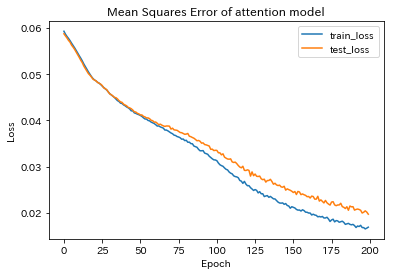

In [35]:
model.train = False

plt.plot(np.array(train_loss_record))
plt.plot(np.array(test_loss_record))
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train_loss','test_loss'])
plt.title('Mean Squares Error of attention model')
plt.show()

In [36]:
train_accuracy = 100*np.sum(np.argmax(model(trainX).data, axis=1)==np.argmax(trainY,axis=1))/len(trainX)
test_accuracy = 100*np.sum(np.argmax(model(testX).data, axis=1)==np.argmax(testY,axis=1))/len(testX)

print('train_accuracy:',train_accuracy)
print('test_accuracy:',test_accuracy)

train_accuracy: 86.13333333333334
test_accuracy: 81.15330520393812
